In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\okarl\Desktop\diploma-thesis\ntbks`


In [2]:
using Plots
using StatsPlots
using JLD
using Statistics
using DataFrames
using ColorSchemes
using LaTeXStrings

In [3]:
DATA_PATH = "../results/"

function load_results(path, n_pars; bayes=false, adjusted=false)
    files = readdir(path)

    results = zeros(length(files), n_pars, 5)
    total_sims = 0

    for i in axes(files)[1]
        data = load(path * files[i])
        
        total_sims += sum(data["total_sims"])

        if adjusted
            data = data["adjusted_particles"]
        elseif bayes
            data = data["particles"]
        else
            data = data["parameters"]
        end

        # mean
        results[i, :, 1] = mean(data, dims=2)
        # median
        results[i, :, 2] = median(data, dims=2)
        # std
        results[i, :, 3] = std(data, dims=2)

        # credible interval/confidence interval
        results[i, :, 4] = hcat([quantile(data[i, :], 0.025) for i in 1:size(data, 1)]) # lower
        results[i, :, 5] = hcat([quantile(data[i, :], 0.975) for i in 1:size(data, 1)]) # upper
    end

    total_sims /= length(files)
    println(total_sims)
    return results
end;


function RMSE(true_params, parameters, stds)
    true_normalizer = deepcopy(true_params)
    true_normalizer[true_params .== 0] .= 1

    true_normalizer = reshape(true_normalizer, ((1, size(true_normalizer)[1])))
    return mean(sqrt.(((parameters .- true_normalizer).^2 + stds.^2) ./ abs.(true_normalizer)))
end;

# ARMA-GARCH

nu = 0.0  
a_1 = 0.7  
b_1 = 0.1  
alpha_1 = 0.1  
beta_1 = 0.3  
omega = 0.001  

In [4]:
TRUE_VALUES = [0.0, 0.7, 0.1, 0.1, 0.3, 0.001];

In [5]:
print("ABC: ")
garch_abc = load_results(DATA_PATH * "result_abc/armagarch_abc/", 6, bayes=true, adjusted=false)
print("Bayes: ")
garch_bayes = load_results(DATA_PATH * "result_bayes/armagarch_bayes/", 6, bayes=true)
print("SMM: ")
garch_smm = load_results(DATA_PATH * "result_smm/armagarch_smm/", 6)
print("NPMSLE: ")
garch_npmsle = load_results(DATA_PATH * "result_npmsle/armagarch_npmsle/", 6);

ABC: 308370.74
Bayes: 300000.0
SMM: 384096.0
NPMSLE: 384096.0


In [6]:
index_level_1 = ["True", "Mean", "Mean", "Mean", "Mean", "Median", "Median", "Median", "Median", "Lower", "Upper", "Lower", "Upper", "Lower", "Upper", "Lower", "Upper", "Std", "Std", "Std", "Std"]
index_level_2 = ["True", "SMM", "NPMSL", "ABC", "Bayes", "SMM", "NPMSL", "ABC", "Bayes", "SMM", "SMM", "NPMSL", "NPMSL", "ABC", "ABC", "Bayes", "Bayes", "SMM", "NPMSL", "ABC", "Bayes"]


column_values = zeros(length(index_level_1), 6)
column_values[1, :] = TRUE_VALUES

for (i, data) in enumerate([garch_smm, garch_npmsle, garch_abc, garch_bayes])
    temp = round.(mean(data, dims=1)[1, :, :], digits=4)

    index = i + 1
    column_values[index, :] = temp[:, 1] # mean
    column_values[index + 4, :] = temp[:, 2] # median
    column_values[index + 8 + i - 1, :] = temp[:, 4] # lower
    column_values[index + 9 + i - 1, :] = temp[:, 5] # upper
    column_values[index + 16, :] = temp[:, 3] # std   
end

garch_df = DataFrame(Index1=index_level_1, Index2=index_level_2, nu=column_values[:, 1], a_1=column_values[:, 2], b_1=column_values[:, 3], 
                    alpha_1=column_values[:, 4], beta_1=column_values[:, 5], omega=column_values[:, 6]);

In [7]:
rmse_smm_mean = RMSE(TRUE_VALUES, mean(garch_smm[:, :, 1], dims=1), std(garch_smm[:, :, 1], dims=1))
rmse_smm_med = RMSE(TRUE_VALUES, mean(garch_smm[:, :, 2], dims=1), std(garch_smm[:, :, 2], dims=1))

rmse_npmsle_mean = RMSE(TRUE_VALUES, mean(garch_npmsle[:, :, 1], dims=1), std(garch_npmsle[:, :, 1], dims=1))
rmse_npmsle_med = RMSE(TRUE_VALUES, mean(garch_npmsle[:, :, 2], dims=1), std(garch_npmsle[:, :, 2], dims=1))

rmse_abc_mean = RMSE(TRUE_VALUES, mean(garch_abc[:, :, 1], dims=1), std(garch_abc[:, :, 1], dims=1))
rmse_abc_med = RMSE(TRUE_VALUES, mean(garch_abc[:, :, 2], dims=1), std(garch_abc[:, :, 2], dims=1));

rmse_bayes_mean = RMSE(TRUE_VALUES, mean(garch_bayes[:, :, 1], dims=1), std(garch_bayes[:, :, 1], dims=1))
rmse_bayes_med = RMSE(TRUE_VALUES, mean(garch_bayes[:, :, 2], dims=1), std(garch_bayes[:, :, 2], dims=1));

In [8]:
mle_garch = load(DATA_PATH * "ols_armagarch.jld")["estimates"]

palette = cgrad(:Set1_4, 4, categorical=true).colors

p1_mean = density(garch_smm[:, 1, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p1_mean, garch_npmsle[:, 1, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p1_mean, garch_abc[:, 1, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p1_mean, garch_bayes[:, 1, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p1_mean, mle_garch[:, 1], label="MLE", color=:grey30, linewidth=1.5)
plot!(p1_mean, [TRUE_VALUES[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_mean, L"\nu", titlefontsize=24)

p2_mean = density(garch_smm[:, 2, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p2_mean, garch_npmsle[:, 2, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p2_mean, garch_abc[:, 2, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p2_mean, garch_bayes[:, 2, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p2_mean, mle_garch[:, 2], label="MLE", color=:grey30, linewidth=1.5)
plot!(p2_mean, [TRUE_VALUES[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_mean, L"a_1", titlefontsize=24)

p3_mean = density(garch_smm[:, 3, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p3_mean, garch_npmsle[:, 3, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p3_mean, garch_abc[:, 3, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p3_mean, garch_bayes[:, 3, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p3_mean, mle_garch[:, 3], label="MLE", color=:grey30, linewidth=1.5)
plot!(p3_mean, [TRUE_VALUES[3]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p3_mean, L"b_1", titlefontsize=24)

p4_mean = density(garch_smm[:, 4, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p4_mean, garch_npmsle[:, 4, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p4_mean, garch_abc[:, 4, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p4_mean, garch_bayes[:, 4, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p4_mean, mle_garch[:, 4], label="MLE", color=:grey30, linewidth=1.5)
plot!(p4_mean, [TRUE_VALUES[4]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p4_mean, L"\alpha_1", titlefontsize=24)

p5_mean = density(garch_smm[:, 5, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p5_mean, garch_npmsle[:, 5, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p5_mean, garch_abc[:, 5, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p5_mean, garch_bayes[:, 5, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p5_mean, mle_garch[:, 5], label="MLE", color=:grey30, linewidth=1.5)
plot!(p5_mean, [TRUE_VALUES[5]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p5_mean, L"\beta_1", titlefontsize=24)

p6_mean = density(garch_smm[:, 6, 1], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p6_mean, garch_npmsle[:, 6, 1], label="NMSLE", color=palette[2], linewidth=1.5)
density!(p6_mean, garch_abc[:, 6, 1], label="ABC", color=palette[3], linewidth=1.5)
density!(p6_mean, garch_bayes[:, 6, 1], label="Bayes", color=palette[4], linewidth=1.5)
density!(p6_mean, mle_garch[:, 6], label="MLE", color=:grey30, linewidth=1.5)
plot!(p6_mean, [TRUE_VALUES[6]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p6_mean, L"\omega", titlefontsize=24)

plot_layout = (3, 2)
plot_garch_mean =plot(p1_mean, p2_mean, p3_mean, p4_mean, p5_mean, p6_mean,
    layout = plot_layout, leftmargin=6Plots.mm,
    legend=true, size=(900,1600)
);


p1_med = density(garch_smm[:, 1, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p1_med, garch_npmsle[:, 1, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p1_med, garch_abc[:, 1, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p1_med, garch_bayes[:, 1, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p1_med, [TRUE_VALUES[1]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p1_med, L"\nu", titlefontsize=24)

p2_med = density(garch_smm[:, 2, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p2_med, garch_npmsle[:, 2, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p2_med, garch_abc[:, 2, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p2_med, garch_bayes[:, 2, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p2_med, [TRUE_VALUES[2]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p2_med, L"a_1", titlefontsize=24)

p3_med = density(garch_smm[:, 3, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p3_med, garch_npmsle[:, 3, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p3_med, garch_abc[:, 3, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p3_med, garch_bayes[:, 3, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p3_med, [TRUE_VALUES[3]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p3_med, L"b_1", titlefontsize=24)

p4_med = density(garch_smm[:, 4, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p4_med, garch_npmsle[:, 4, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p4_med, garch_abc[:, 4, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p4_med, garch_bayes[:, 4, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p4_med, [TRUE_VALUES[4]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p4_med, L"\alpha_1", titlefontsize=24)

p5_med = density(garch_smm[:, 5, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p5_med, garch_npmsle[:, 5, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p5_med, garch_abc[:, 5, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p5_med, garch_bayes[:, 5, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p5_med, [TRUE_VALUES[5]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p5_med, L"\beta_1", titlefontsize=24)

p6_med = density(garch_smm[:, 6, 2], label="SMM", color=palette[1], linewidth=1.5, legendfontsize=12)
density!(p6_med, garch_npmsle[:, 6, 2], label="NPMSLE", color=palette[2], linewidth=1.5)
density!(p6_med, garch_abc[:, 6, 2], label="ABC", color=palette[3], linewidth=1.5)
density!(p6_med, garch_bayes[:, 6, 2], label="Bayes", color=palette[4], linewidth=1.5)
plot!(p6_med, [TRUE_VALUES[6]], seriestype="vline", label="True", color="black", linewidth=2.5)
title!(p6_med, L"\omega", titlefontsize=24)

plot_layout = (3, 2)
plot_garch_med =plot(p1_med, p2_med, p3_med, p4_med, p5_med, p6_med,
    layout = plot_layout, leftmargin=6Plots.mm,
    legend=true, size=(900,1600)
);

In [9]:
println(garch_df)

21×8 DataFrame
 Row │ Index1  Index2  nu       a_1      b_1      alpha_1  beta_1   omega   
     │ String  String  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼──────────────────────────────────────────────────────────────────────
   1 │ True    True     0.0      0.7      0.1      0.1      0.3      0.001
   2 │ Mean    SMM      0.0      0.677    0.1323   0.0803   0.1768   0.0012
   3 │ Mean    NPMSL    0.0      0.6976   0.1038   0.102    0.1828   0.0011
   4 │ Mean    ABC      0.0      0.6935   0.1061   0.072    0.2719   0.0011
   5 │ Mean    Bayes    0.0      0.6975   0.1031   0.1105   0.5575   0.0005
   6 │ Median  SMM      0.0      0.6812   0.125    0.0771   0.1403   0.0013
   7 │ Median  NPMSL    0.0      0.6977   0.1037   0.1003   0.1431   0.0012
   8 │ Median  ABC      0.0      0.6935   0.1063   0.07     0.2319   0.0011
   9 │ Median  Bayes    0.0      0.6976   0.1027   0.1102   0.5831   0.0005
  10 │ Lower   SMM     -0.0031   0.5991   0.0445   0.0074   0.0058   0.

In [10]:
println("Mean parameters RMSE")
println("SMM:     $rmse_smm_mean")
println("NMSLE:   $rmse_npmsle_mean")
println("ABC:     $rmse_abc_mean")
println("Bayes:   $rmse_bayes_mean")
println()
println("Median parameters RMSE")
println("SMM:     $rmse_smm_med")
println("NMSLE:   $rmse_npmsle_med")
println("ABC:     $rmse_abc_med")
println("Bayes:   $rmse_bayes_med")

Mean parameters RMSE
SMM:     0.2537288384871843
NMSLE:   0.23326066452107866
ABC:     0.22713030486431196
Bayes:   0.2901428003375152

Median parameters RMSE
SMM:     0.2642086790248443
NMSLE:   0.2454194675844965
ABC:     0.23848466505367258
Bayes:   0.30150367913171244


### Mean parameters

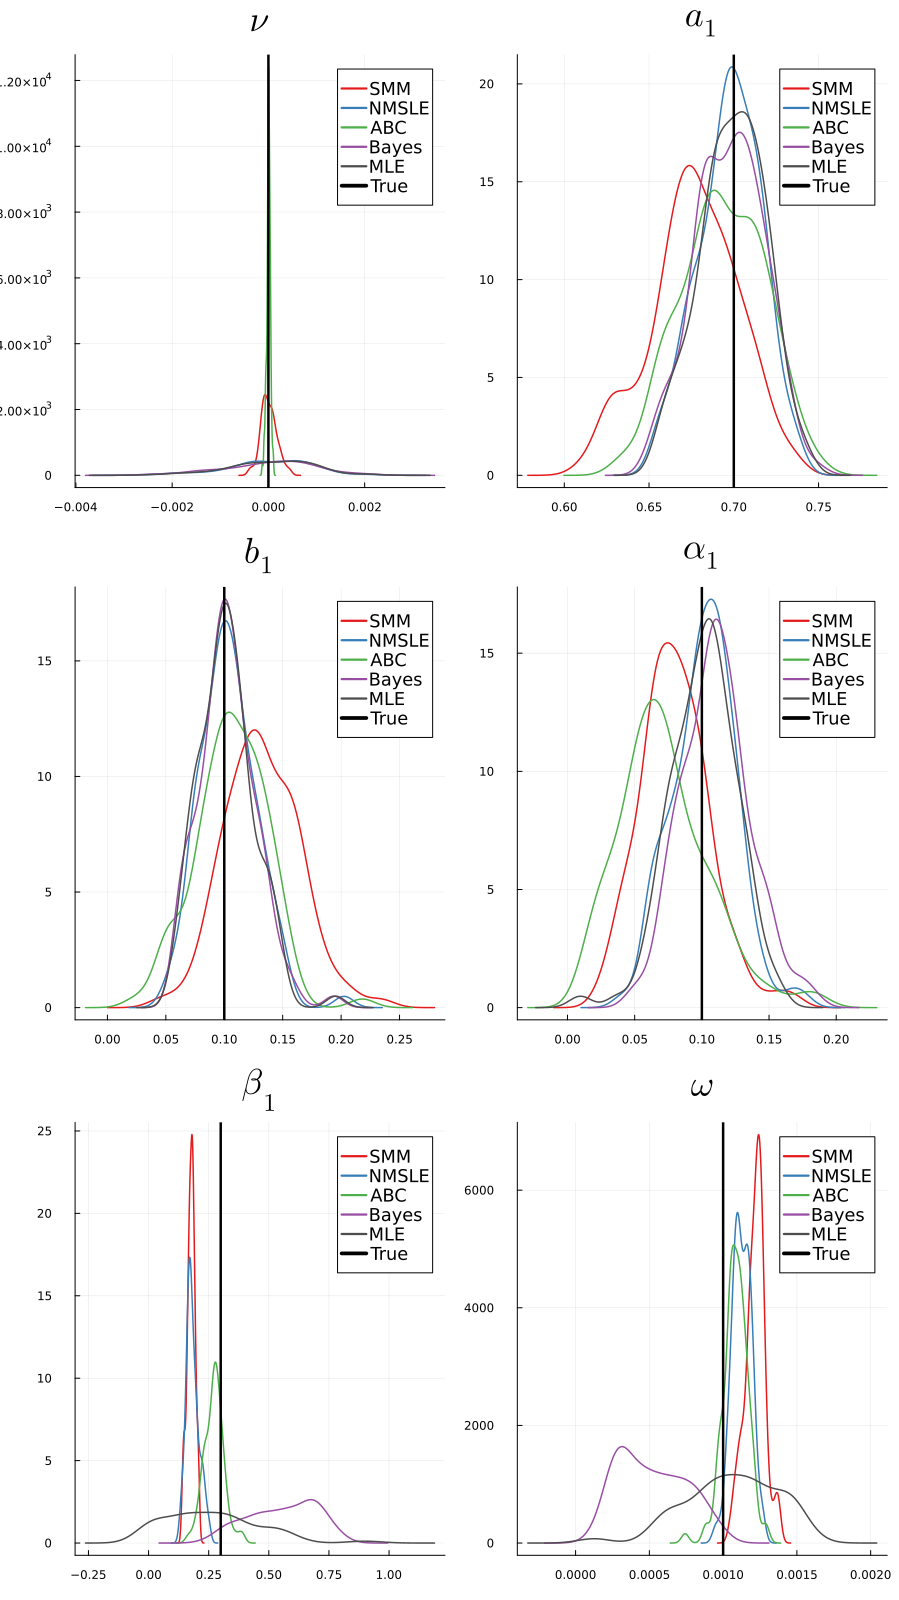

In [11]:
plot_garch_mean

In [12]:
savefig(plot_garch_mean, "../plots/armagarch_plot_mean.png")

"C:\\Users\\okarl\\Desktop\\diploma-thesis\\plots\\armagarch_plot_mean.png"

### Median parameters

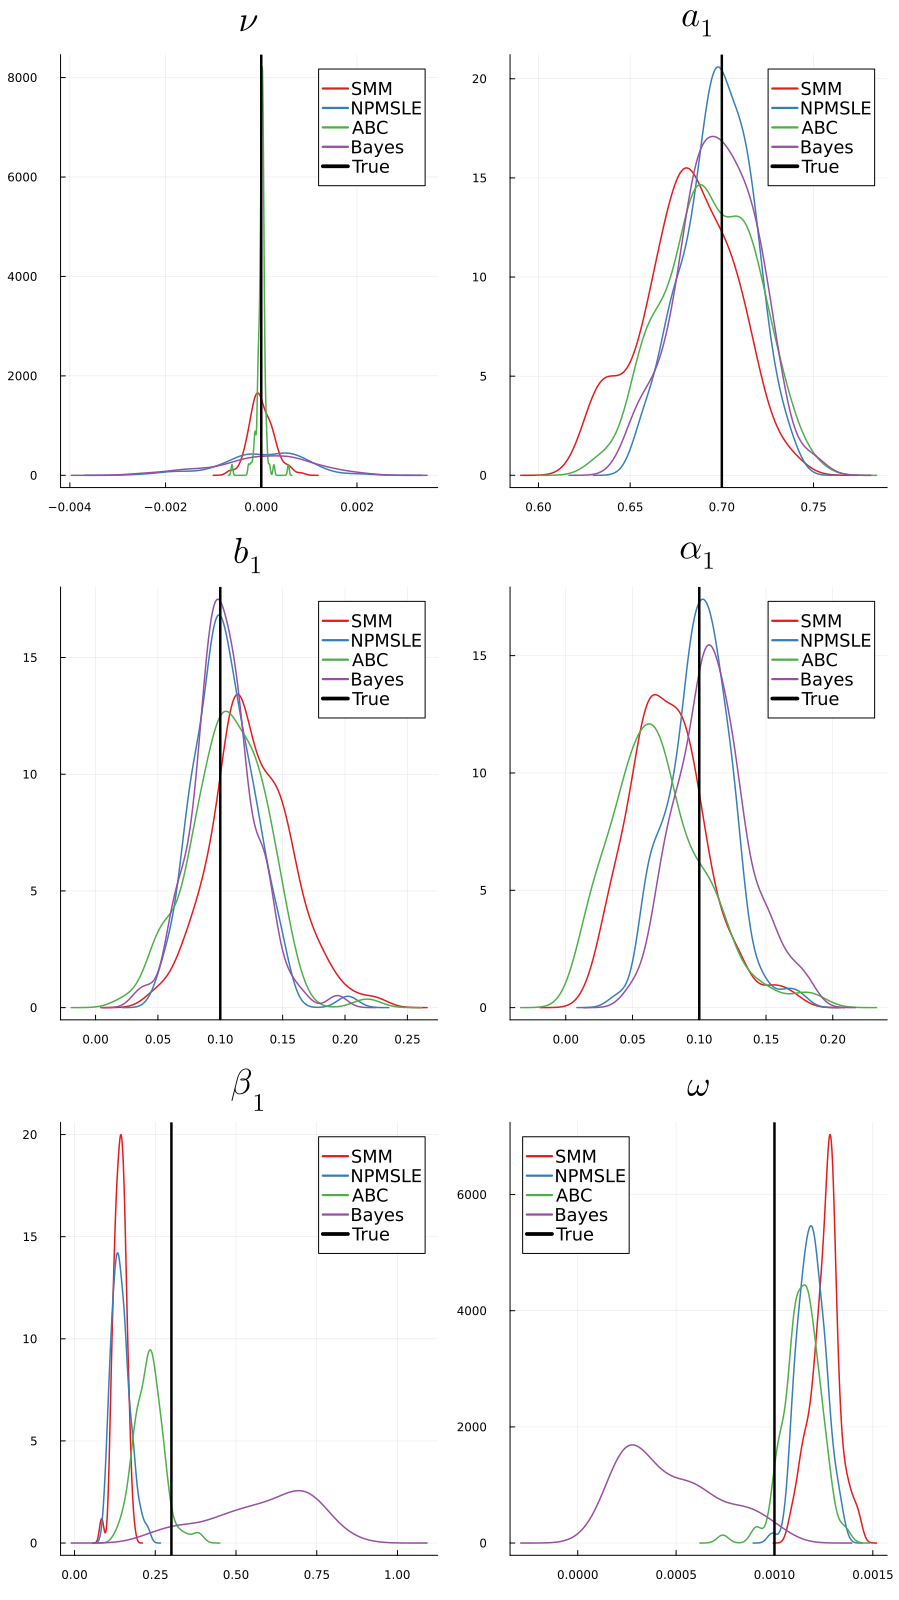

In [13]:
plot_garch_med